In [1]:
import gc
import os
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
import logging
import sys
from contextlib import contextmanager
from PIL import Image
project_root = "/Users/heydari/Documents/TEMA-FHHI-PY/FHHI-XAI/"
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Assuming LCRP and src modules are available in the Python path or current directory
# You might need to adjust sys.path if they are not.
#import sys
sys.path.append('/Users/heydari/Documents/TEMA-FHHI-PY/FHHI-XAI/LCRP')
# sys.path.append('/path/to/your/src')

from LCRP.models import get_model 
from src.plot_crp_explanations import plot_one_image_explanation, fig_to_array
from src.plot_pcx_explanations_YOLO import plot_one_image_pcx_explanation
from src.datasets.person_car_dataset import PersonCarDataset
from src.datasets.flood_dataset import FloodDataset
from src.plot_pcx_all import plot_pcx_explanations_pidnet
from src.entities import get_person_vehicle_detection_explanation_entity, get_flood_segmentation_explanation_entity
import os
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from datetime import datetime
from tqdm import tqdm
from torchvision.utils import make_grid

# === CRP & Zennit ===
import zennit.image as zimage
from crp.image import imgify
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names

# Mock FHHI_MINIO_BUCKET if minio_client is not fully set up for standalone execution
try:
    from src.minio_client import FHHI_MINIO_BUCKET
except ImportError:
    print("Warning: src.minio_client not found or not fully configured. Using a mock bucket name.")
    FHHI_MINIO_BUCKET = "mock-bucket"

# Mock log_cuda_memory if not fully configured for standalone execution
try:
    from src.memory_logging import log_cuda_memory
except ImportError:
    print("Warning: src.memory_logging not found. Using a mock log_cuda_memory function.")
    def log_cuda_memory(logger, stage):
        logger.info(f"Mock CUDA memory log at stage: {stage}")

# Setup basic logging for demonstration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

/Users/heydari/anaconda3/envs/tema-py/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


In [2]:
class Explanator:
    """Class that stores all loaded models together with all relevant data for generating CRP explanations.
    
    This is the main class used in the TFA-02 component. 
    """
    
    def __init__(self, project_root: str, logger: logging.Logger):
        self.logger = logger
        # General setup
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.dtype = torch.float32
        
        # Log initial memory state
        log_cuda_memory(self.logger, "INIT")

        self.project_root = project_root

        # Lazy loading approach - don't load models until needed
        self._person_vehicle_model = None
        self._person_car_dataset = None
        self._flood_model = None
        self._flood_dataset = None

        # Create a mapping from entity types to handler methods
        self.entity_handlers = {
            "BurntSegmentation": self.explain_burnt_segmentation,
            "FireSegmentation": self.explain_fire_segmentation,
            "FloodSegmentation": self.explain_flood_segmentation,
            "PersonVehicleDetection": self.explain_person_vehicle_detection,
            "SmokeSegmentation": self.explain_smoke_segmentation,
            "EOBurntArea": self.explain_eo_burnt_area,
            "EOFloodExtent": self.explain_eo_flood_extent,
            "ImageMetadata": None,
        }

        self.VALID_ENTITY_TYPES = list(self.entity_handlers.keys())
        self.DLR_ENTITY_TYPES = {"EOBurntArea", "EOFloodExtent"}

        self.running_avg_forward_time = 0
        self.forward_count = 0
        self.running_avg_backward_time = 0
        self.backward_count = 0

    @property 
    def prediction_times(self):
        """Returns the average forward and backward pass times."""
        return {
            "forward": f"{self.running_avg_forward_time:.3f} ms",
            "backward": f"{self.running_avg_backward_time:.3f} ms",
        }

    @contextmanager
    def record_forward_time(self):
        """Context manager to record the time taken for a forward pass."""
        if self.device == "cuda" and torch.cuda.is_available():
            self.logger.debug("Using CUDA for timing")
            try:
                # Try using CUDA events for timing on GPU
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
                start_time.record()
                yield
                end_time.record()
                # Wait for the events to be recorded
                torch.cuda.synchronize()
                elapsed_time = start_time.elapsed_time(end_time)
            except (TypeError, RuntimeError):
                # Fall back to time.time() if CUDA events fail
                import time
                start_time = time.time()
                yield
                elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        else:
            self.logger.debug("Using CPU for timing")
            print()
            # Use time.time() for timing on CPU
            import time
            start_time = time.time()
            yield
            elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        
        # The formula for the running average is:
        # new_average = old_average + (new_value - old_average) / new_count
        self.forward_count += 1
        self.running_avg_forward_time += (elapsed_time - self.running_avg_forward_time) / self.forward_count
        self.logger.debug(f"Forward pass time: {elapsed_time:.2f} ms")
        self.logger.debug(f"Running average forward pass time: {self.running_avg_forward_time:.2f} ms")

    def explain(self, entity_type: str, original_image_bucket: str, original_image_filename: str, image: np.ndarray):
        """Generate explanation for the given entity type and image."""
        log_cuda_memory(self.logger, f"BEFORE EXPLAIN {entity_type}")

        if entity_type not in self.VALID_ENTITY_TYPES:
            raise ValueError(f"Invalid entity type: {entity_type}. Must be one of {self.VALID_ENTITY_TYPES}")

        # Get the appropriate handler method for this entity type
        handler = self.entity_handlers.get(entity_type)

        # Call the handler method with the image
        result = handler(original_image_bucket, original_image_filename, image)

        log_cuda_memory(self.logger, f"AFTER EXPLAIN {entity_type}")
        # Clear unnecessary tensors from cache
        torch.cuda.empty_cache()

        return result

    def explain_eo_burnt_area(self, original_image_bucket: str, original_image_filename: str, image: np.ndarray):
        raise NotImplementedError("EO Burnt Area explanation is not implemented yet.")
 
    def explain_eo_flood_extent(self, original_image_bucket: str, original_image_filename: str, image: np.ndarray):
        raise NotImplementedError("EO Flood Extent explanation is not implemented yet.")

    def explain_burnt_segmentation(self, original_image_bucket: str, original_image_filename: str, image: np.ndarray):
        raise NotImplementedError("Burnt segmentation explanation is not implemented yet.")

    def explain_fire_segmentation(self, original_image_bucket: str, original_image_filename: str, image: np.ndarray):
        raise NotImplementedError("Fire segmentation explanation is not implemented yet.")

    @property
    def flood_model(self):
        if self._flood_model is None:
            log_cuda_memory(self.logger, "BEFORE LOADING FLOOD MODEL")
            model_name = "pidnet"
            flood_model_path = os.path.join(self.project_root, "models", "flood_s_best_pidnet_modified.pt")
            self._flood_model = get_model(model_name=model_name, classes=2, ckpt_path=flood_model_path, device=self.device, dtype=self.dtype)
            log_cuda_memory(self.logger, "AFTER LOADING FLOOD MODEL")
        return self._flood_model

    @property
    def flood_dataset(self):
        if self._flood_dataset is None:
            flood_data_path = os.path.join(self.project_root, "data", "General_Flood_v3")

            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.to(self.dtype)),
            ])

            self._flood_dataset = FloodDataset(root_dir=flood_data_path, split="train", transform=transform)
        return self._flood_dataset

 
        
    def explain_flood_segmentation(self, original_image_bucket: str, original_image_filename: str, image: np.ndarray):
        """Generate flood segmentation explanation using PCX."""
        log_cuda_memory(self.logger, "FLOOD_SEG START")

        # Parameters
        class_id = 1  # Flood class ID
        n_concepts = 3
        n_refimgs = 12
        model_name = "pidnet"
        num_prototypes = 2
        output_dir_pcx = "output/pcx/pidnet_flood/"
        output_dir_crp = "output/crp/pidnet_flood/"
        ref_imgs_path = "output/ref_imgs_pidnet/"
        layer_names = get_layer_names(self.flood_model, [torch.nn.Conv2d])
        layer_name = layer_names[2]
        print(layer_name)
        folder = f"../output/pcx/pidnet_flood/{layer_name}/"
        attributions = torch.from_numpy(np.load(folder + "attributions.npy"))
        activations = torch.from_numpy(np.load(folder + "activations.npy"))
        indices = np.arange(len(self.flood_dataset))

        # Apply transform to the input test image
        log_cuda_memory(self.logger, "BEFORE IMAGE TRANSFORM")
        image_tensor = self.flood_dataset.transform(image)
        image_tensor = self.flood_dataset.resize(image_tensor)
        log_cuda_memory(self.logger, "AFTER IMAGE TRANSFORM")
        
        print("Shape after batch dimension:", image_tensor.shape)



        log_cuda_memory(self.logger, "BEFORE EXPLANATION GENERATION")
        explanation_fig = plot_pcx_explanations_pidnet("pidnet", self.flood_model, self.flood_dataset, image_tensor=image_tensor, n_concepts=5, n_refimgs=12,
        num_prototypes=num_prototypes, layer_name=layer_name,
        ref_imgs_path=ref_imgs_path, output_dir_pcx=output_dir_pcx, output_dir_crp=output_dir_crp
        )


        
        # fig is returned implicitly as part of this function; adapt if needed
        log_cuda_memory(self.logger, "AFTER EXPLANATION GENERATION")

        explanation_img = fig_to_array(explanation_fig)

        # Prepare explanation entity
        original_entity_type = "FloodSegmentation"
        explanation_image_filename = f"tfa02/{original_entity_type}/{original_image_filename}"

        explanation_entity = get_flood_segmentation_explanation_entity(
            original_image_bucket=original_image_bucket,
            original_image_filename=original_image_filename,
            explanation_image_bucket=FHHI_MINIO_BUCKET,
            explanation_image_filename=explanation_image_filename,
            class_id=class_id,
            n_concepts=n_concepts,
            n_refimgs=n_refimgs,
            layer=layer_name,
            mode="relevance"
        )

        log_cuda_memory(self.logger, "FLOOD_SEG END")
        torch.cuda.empty_cache()

        return explanation_entity, [explanation_img], [explanation_image_filename]
        



    @property
    def person_vehicle_model(self):
        if self._person_vehicle_model is None:
            log_cuda_memory(self.logger, "BEFORE LOADING PERSON VEHICLE MODEL")
            self._person_vehicle_model = self.load_person_vehicle_model()
            log_cuda_memory(self.logger, "AFTER LOADING PERSON VEHICLE MODEL")
        return self._person_vehicle_model
    
    @property
    def person_car_dataset(self):
        if self._person_car_dataset is None:
            self._person_car_dataset = self.load_person_car_data()
        return self._person_car_dataset

    def load_person_vehicle_model(self):
        # Load the person/vehicle detection model
        model_name = "yolov6s6"
        person_vehicle_model_path = os.path.join(self.project_root, "models" , "best_v6s6_ckpt.pt")
        return get_model(model_name=model_name, classes=2, ckpt_path=person_vehicle_model_path, device=self.device, dtype=self.dtype)

    def load_person_car_data(self):
        transform = transforms.Compose([
            transforms.ToTensor(),  # Convert to tensor
            transforms.Resize((1280, 1280)),
            transforms.Lambda(lambda x: x.to(self.dtype)), 
        ])

        person_car_data_path = os.path.join(self.project_root, "data" , "person_car_detection_data", "Arthal")
        dataset = PersonCarDataset(root_dir=person_car_data_path, split="train", transform=transform)
        return dataset

    def explain_person_vehicle_detection(self, original_image_bucket: str, original_image_filename: str, image: np.ndarray):
        """Generate person/vehicle detection explanation."""
        original_entity_type = "PersonVehicleDetection"
        original_filename_no_ext = os.path.splitext(original_image_filename)[0]

        log_cuda_memory(self.logger, "PERSON_VEHICLE START")

        model_name = "yolov6s6"
        n_concepts = 3
        n_refimgs = 12
        # This one was used before for CRP
        # layer = "module.backbone.ERBlock_6.2.cspsppf.cv7.block.conv"
        # This one suggested by Jawher for PCX
        layer = 'module.backbone.ERBlock_3.0.rbr_dense.conv'
        prototype_dict = {0: 4, 1: 5}

        mode = "relevance"

        crp_output_dir = "output/crp/yolo_person_car"
        pcx_output_dir = "output/pcx/yolo_person_car"
        ref_imgs_path = "output/ref_imgs_12"

        # Apply transform
        log_cuda_memory(self.logger, "BEFORE IMAGE TRANSFORM")
        image_tensor = self.person_car_dataset.transform(image)
        log_cuda_memory(self.logger, "AFTER IMAGE TRANSFORM")

        # We need to run the model to get the predicted boxes
        test_img = self.person_car_dataset.transform(image)
        test_img = test_img.unsqueeze(0)

        test_img = test_img.to(self.device)

        with self.record_forward_time():
            scores, boxes = self.person_vehicle_model.predict_with_boxes(test_img)
        num_boxes = boxes.shape[1]
        self.logger.debug(f"Number of boxes: {num_boxes}")

        # Only for debug
        # self.logger.warning(f"Changing num_boxes from {num_boxes} to 2 for debug")
        # num_boxes = 2

        boxes = boxes[0].cpu().detach().numpy().tolist()

        class_ids = scores[0].argmax(dim=1)
        confidences = scores[0].max(dim=1).values

        explanation_images = []
        explanation_image_filenames = []
        
        explanation_boxes = []
        for prediction_num in range(num_boxes):

            exp_box = {}

            exp_box["object_id"] = prediction_num
            exp_box["bbox"] = boxes[prediction_num]
            class_id = class_ids[prediction_num].item()
            confidence = confidences[prediction_num].item()
            exp_box["class_id"] = class_id
            exp_box["confidences"] = confidence

            self.logger.debug(f"Generating explanation for box {prediction_num} of {num_boxes}")
            log_cuda_memory(self.logger, f"BEFORE BOX {prediction_num}")
            
            # Clear cache before each box processing
            torch.cuda.empty_cache()
            
            # CRP visualization
            # explanation_fig = plot_one_image_explanation(
            #     model_name, self.person_vehicle_model, image_tensor, 
            #     self.person_car_dataset, class_id, layer, prediction_num, 
            #     mode, n_concepts, n_refimgs, output_dir=glocal_analysis_output_dir
            # )

            # PCX visualization
            explanation_fig = plot_one_image_pcx_explanation(
                model_name, self.person_vehicle_model, image_tensor,
                self.person_car_dataset, class_id, n_concepts, n_refimgs,
                num_prototypes=prototype_dict,
                prediction_num=prediction_num,
                layer_name=layer,
                ref_imgs_path=ref_imgs_path,
                output_dir_pcx=pcx_output_dir,
                output_dir_crp=crp_output_dir,
                outside_logger=self.logger,
            )
            
            explanation_img = fig_to_array(explanation_fig)
            explanation_images.append(explanation_img)
            
            explanation_file_name = f"tfa02/{original_entity_type}/{original_filename_no_ext}/object_{prediction_num}.png"
            explanation_image_filenames.append(explanation_file_name)
            
            exp_box["explanation_image"] = explanation_file_name
            exp_box["explanation_image_bucket"] = FHHI_MINIO_BUCKET
            
            log_cuda_memory(self.logger, f"AFTER BOX {prediction_num}")
            
            # Force garbage collection after each box
            gc.collect()
            torch.cuda.empty_cache()
            explanation_boxes.append(exp_box)
        
        explanation_entity = get_person_vehicle_detection_explanation_entity(
            original_image_bucket=original_image_bucket,
            original_image_filename=original_image_filename,
            original_detection_boxes=boxes,
            original_detection_class_categories=class_ids.cpu().detach().numpy().tolist(),
            original_detection_confidences=confidences.cpu().detach().numpy().tolist(),
            explanation_boxes=explanation_boxes,
            n_concepts=n_concepts,
            n_refimgs=n_refimgs,
            layer=layer,
            mode=mode,
        )
        self.logger.warning(f"explanation_entity: {explanation_entity}")

        log_cuda_memory(self.logger, "PERSON_VEHICLE END")
        torch.cuda.empty_cache()

        return explanation_entity, explanation_images, explanation_image_filenames


    def explain_smoke_segmentation(self, src_entity: dict, image: np.ndarray):
        raise NotImplementedError("Smoke segmentation explanation is not implemented yet.")

In [3]:
import os
import logging # Make sure logging is imported if not already

# Configure basic logging if not done elsewhere
if not logging.getLogger().handlers:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set your project root directory.
# Adjust this path to where your 'models', 'data', 'LCRP', and 'src' directories are located.
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
logger.info(f"Project Root set to: {project_root}")

# THIS IS WHERE THE 'explanator' OBJECT IS CREATED
explanator = Explanator(project_root=project_root, logger=logger)
logger.info("Explanator initialized successfully.")

INFO:__main__:Project Root set to: /Users/heydari/Documents/TEMA-FHHI-PY/FHHI-XAI
INFO:__main__:INIT CUDA not available
INFO:__main__:Explanator initialized successfully.


INFO:__main__:BEFORE EXPLAIN FloodSegmentation CUDA not available
INFO:__main__:FLOOD_SEG START CUDA not available
INFO:__main__:BEFORE LOADING FLOOD MODEL CUDA not available
INFO:__main__:AFTER LOADING FLOOD MODEL CUDA not available
INFO:__main__:BEFORE IMAGE TRANSFORM CUDA not available
INFO:__main__:AFTER IMAGE TRANSFORM CUDA not available
INFO:__main__:BEFORE EXPLANATION GENERATION CUDA not available



--- Explaining Flood Segmentation ---
Could not load or create image for flood explanation: 'str' object has no attribute 'plot'. Creating a generic dummy image.
Loading checkpoint from: /Users/heydari/Documents/TEMA-FHHI-PY/FHHI-XAI/models/flood_s_best_pidnet_modified.pt
layer1.0.conv1
Shape after batch dimension: torch.Size([3, 480, 480])


ERROR:LCRP.utils.crp:Prediction time: 0.22565412521362305, Backward time: 0.15744423866271973, Full attribution time: 0.16394901275634766
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\xf0\x15'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\xa0\x0e'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 230 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: ImageDescription (270) - type: string (2) Tag Location: 70 - Data Location: 236 - value: <table: 322 bytes>
DEBUG:PIL.TiffImagePlugin:tag: Make (271) - type: string (2) Tag Location: 82 - Data Location: 558 - value: b'Canon\x00'
DEBUG:PIL.TiffImagePlugin:tag: Model (272) - type: string (2) Tag Location: 94 - Data Location: 564 - value: b'Canon EOS-1D X\x00'
DEBUG:PIL.TiffImagePlugin:tag: Orientation (274) -

Reference image file does not exist, calculating all.


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1765
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 5068
DEBUG:PIL.TiffImagePlugin:tag: XResolution (282) - type: rational (5) Tag Location: 70 - Data Location: 870 - value: b'H\x00\x00\x00\x01\x00\x00\x00'
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 3362
DEBUG:PIL.TiffImagePlugin:tag: ImageDescription (270) - type: string (2) Tag Location: 70 - Data Location: 188 - value: <table: 489 bytes>
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.TiffImagePlugin:tag: YResolution (283) - type: rational (5) Tag Location: 82 - Data Location: 878 - value: b'H\x00\x00\x00\x01\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: Orientation (274) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: Software (3

Flood Explanation Entity:
[{'id': 'urn:ngsi-ld:tema:FHHI:TFA-02:FloodSegmentationExplanation:fhhi-tfa02_auth-tfa06_001', 'type': 'FloodSegmentationExplanation', 'creator': {'type': 'Property', 'value': 'FHHI (TFA-02)'}, 'title': {'type': 'Property', 'value': 'Flood Segmentation Explanation.'}, 'description': {'type': 'Property', 'value': 'Explanation created by FHHI (TFA-02) for AUTH (TFA-06) related to flood segmentation.'}, 'bucket': {'type': 'Property', 'value': 'fhhi'}, 'explainsEntity': {'type': 'Relationship', 'object': 'urn:ngsi-ld:tema:AUTH:TFA-06:FloodSegmentation'}, 'targetComponent': {'type': 'Property', 'value': 'AUTH (TFA-06)'}, 'timestamp': {'type': 'Property', 'value': '2025-08-11T13:03:48.056416'}, 'original_image': {'type': 'Property', 'value': {'bucket': 'data/General_Flood_v3/RGB/train/JPEG', 'filename': 'image_0.jpg'}}, 'explanation_image': {'type': 'Property', 'value': {'bucket': 'fhhi', 'filename': 'tfa02/FloodSegmentation/image_0.jpg'}}, 'explanation': {'type': '

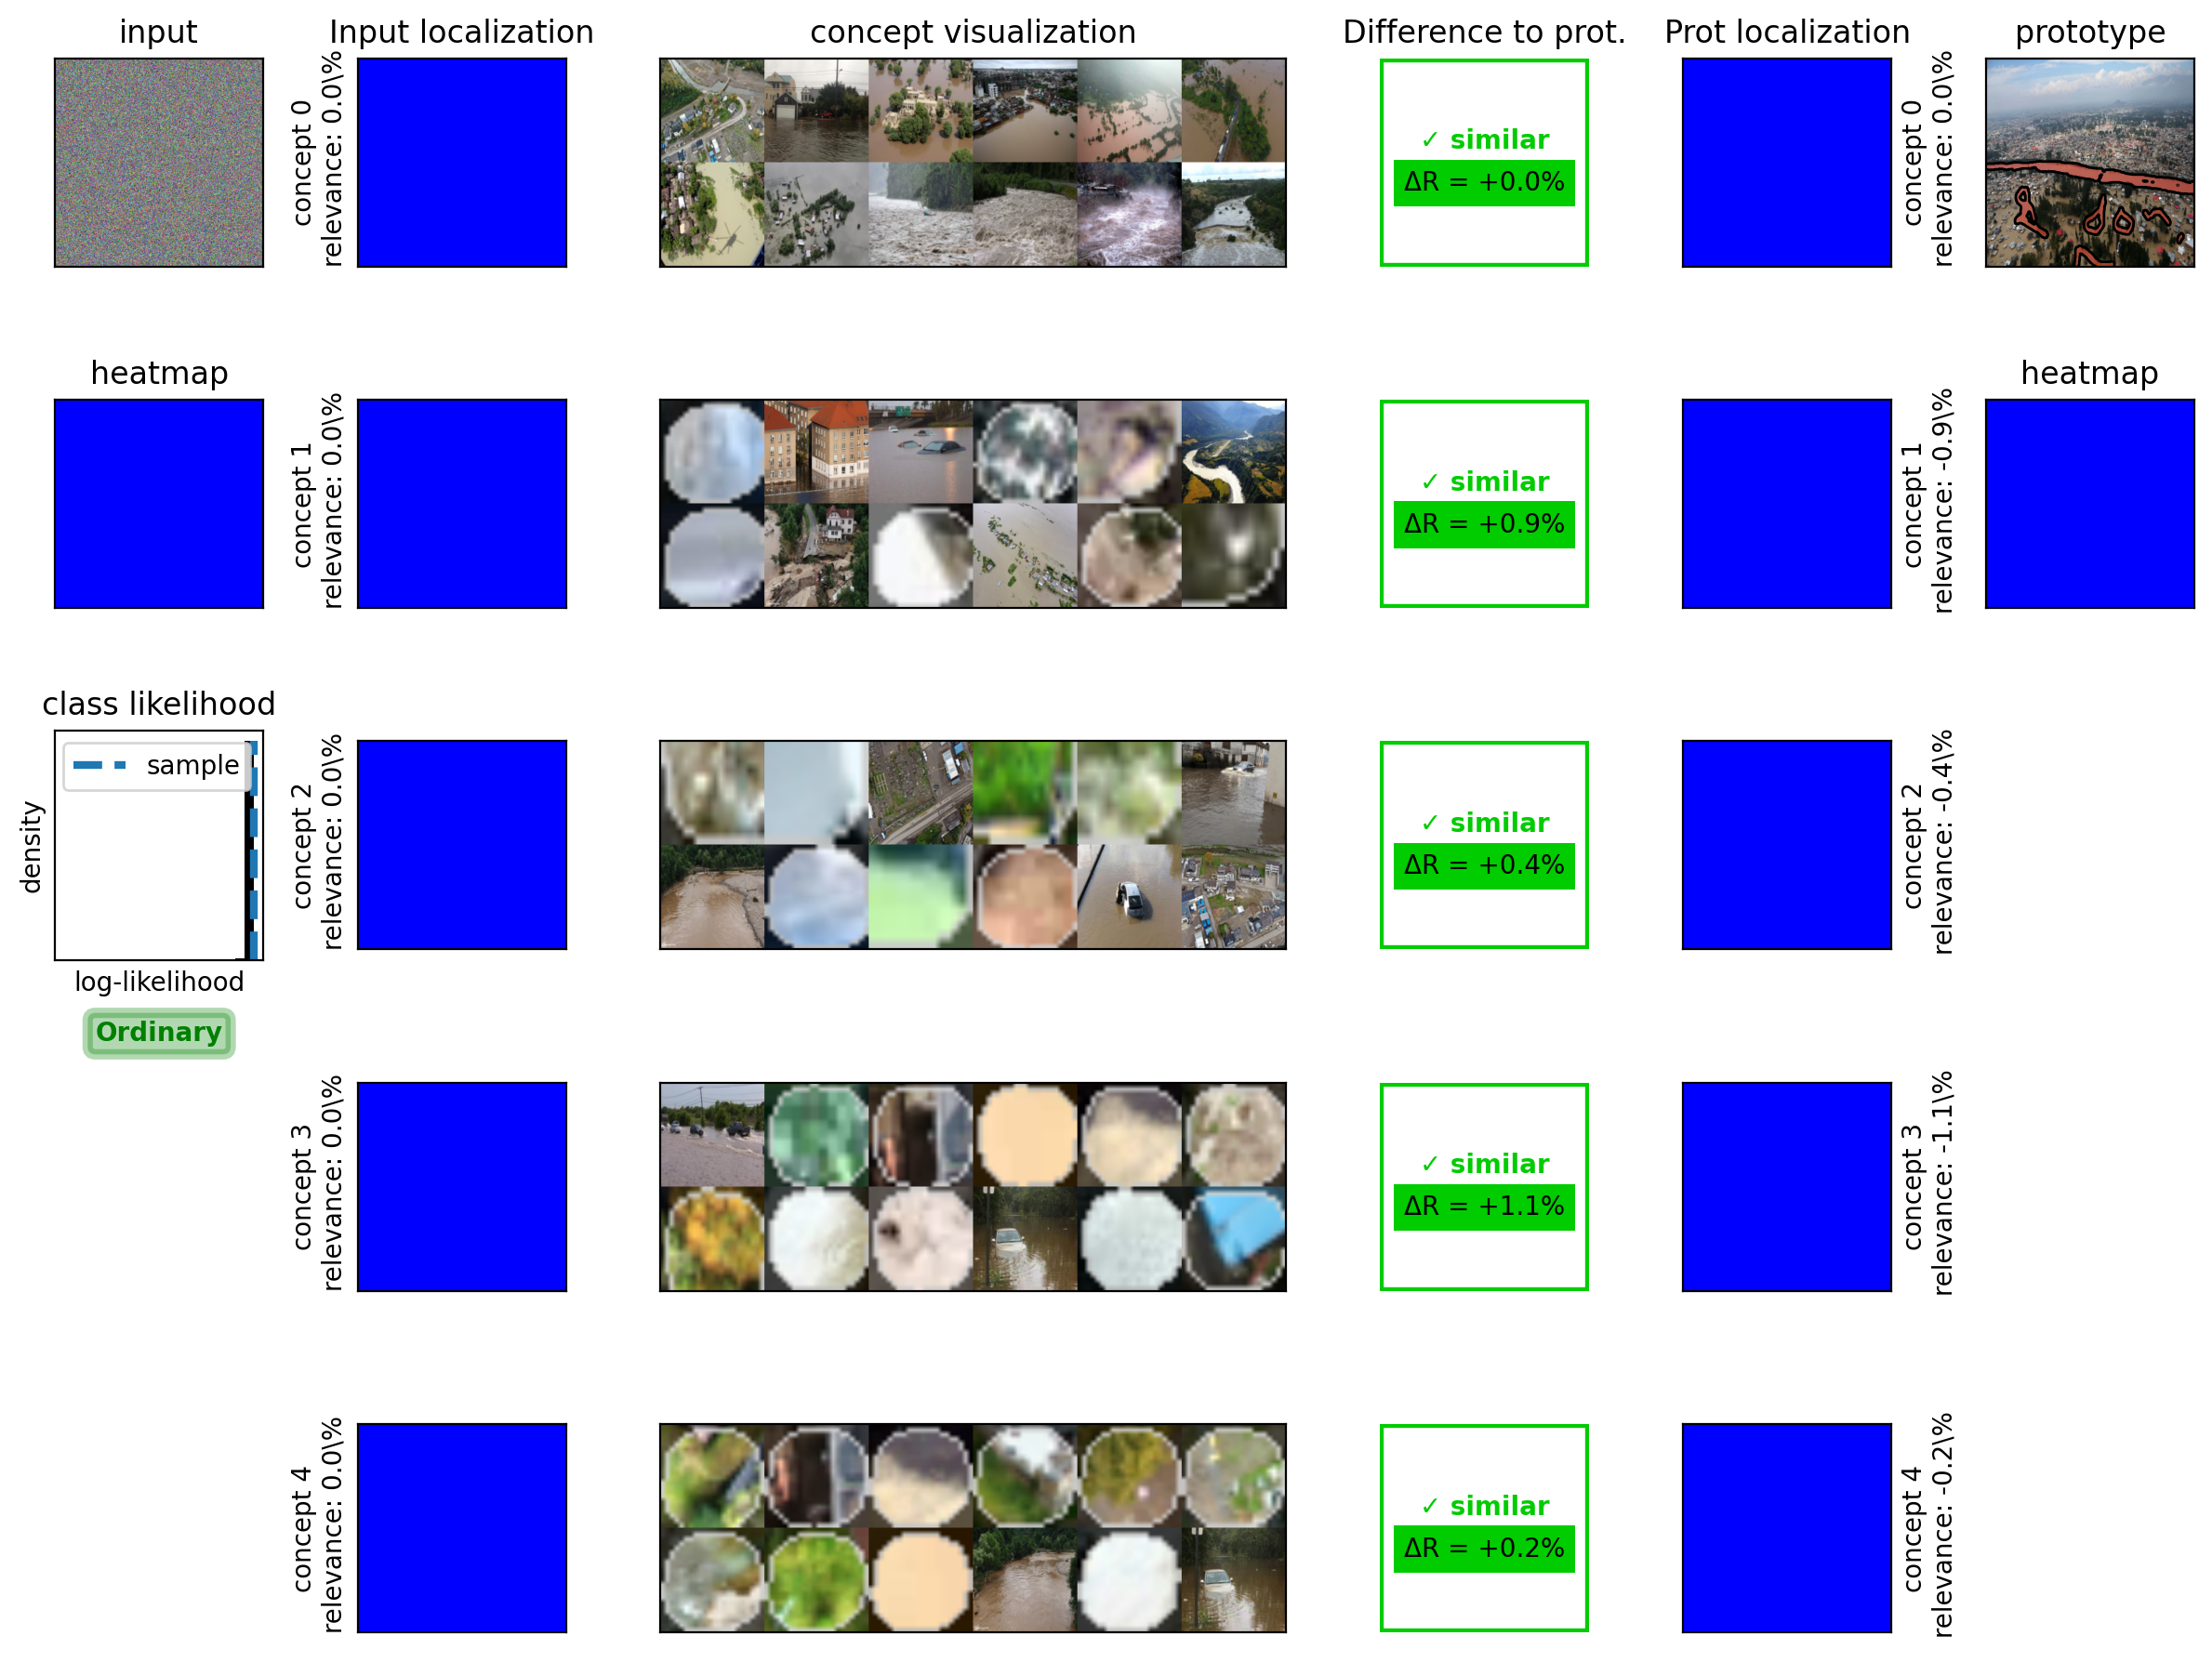

DEBUG:matplotlib.font_manager:findfont: Matching DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/heydari/anaconda3/envs/tema-py/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/heydari/anaconda3/envs/tema-py/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/heydari/anaconda3/envs/tema-py/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) =

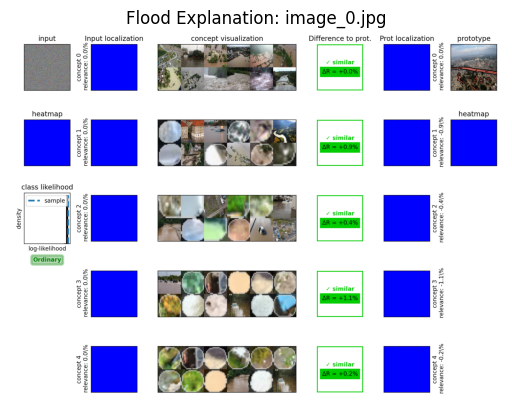

In [4]:
# Example for Flood Segmentation
print("\n--- Explaining Flood Segmentation ---")
original_image_bucket_flood = "data/General_Flood_v3/RGB/train/JPEG"
original_image_filename_flood = "image_0.jpg"

# Create a dummy image for demonstration if you don't have one
try:
    # Attempt to load a real image (adjust path as needed)
    # This path is a common structure for datasets, e.g., 'data/General_Flood_v3/images/train/some_image.jpg'
    #sample_image_path_flood = os.path.join(project_root, "data", "General_Flood_v3", "RGB", "train", "JPEG",original_image_filename_flood) 

    sample_image_path_flood = 'data/General_Flood_v3/RGB/train/JPEG/image_0.jpg'
    sample_image_path_flood.plot()
    if not os.path.exists(sample_image_path_flood):
        # Fallback to a generated dummy image if real one not found
        print(f"Sample flood image not found at {sample_image_path_flood}. Creating a dummy image.")
        dummy_image_flood = np.random.randint(20, 256, (512, 512, 3), dtype=np.uint8) # Common size for segmentation
        Image.fromarray(dummy_image_flood).save(original_image_filename_flood) # Save to current notebook directory
        image_flood = Image.open(original_image_filename_flood).convert('RGB')
    else:
        image_flood = Image.open(sample_image_path_flood).convert('RGB')
    image_flood_np = np.array(image_flood)
except Exception as e:
    print(f"Could not load or create image for flood explanation: {e}. Creating a generic dummy image.")
    image_flood_np = np.random.randint(0, 256, (512, 512, 3), dtype=np.uint8) # Default dummy if all fails

try:
    flood_explanation_entity, flood_explanation_imgs, flood_explanation_filenames = \
        explanator.explain(
            entity_type="FloodSegmentation", 
            original_image_bucket=original_image_bucket_flood, 
            original_image_filename=original_image_filename_flood, 
            image=image_flood_np
        )
    
    print("Flood Explanation Entity:")
    print(flood_explanation_entity)
    
    print("Flood Explanation Images (first one displayed):")
    if flood_explanation_imgs:
        plt.figure() # Adjust figure size for better display
        plt.imshow(flood_explanation_imgs[0])
        plt.title(f"Flood Explanation: {flood_explanation_filenames[0].split('/')[-1]}")
        plt.axis('off')
        plt.show()

except NotImplementedError as e:
    print(f"Skipping Flood Segmentation explanation: {e}")
except Exception as e:
    print(f"Error during Flood Segmentation explanation: {e}")
    # If model/data loading fails, you might get more specific errors here.
    # Ensure your project_root is correctly set and models/data are present.